# StringSight Starter Notebook

This notebook demonstrates how to use StringSight to analyze model behavior from conversation data.

We'll cover:
- Loading and preparing data
- Single model analysis with `explain()`
- Side-by-side comparison with `explain()`
- Fixed taxonomy labeling with `label()`
- Viewing results and metrics
- Key parameters and customization options

## Setup

In [2]:
# install stringsight if you haven't already

#  ! pip install stringsight

In [3]:
import pandas as pd
import json
from stringsight import explain

# Optional: Set your OpenAI API key if not already in environment
# import os
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

## Load Data

We'll use the TauBench airline demo dataset. Let's load it and examine its structure.

In [ ]:
# Load the JSONL data
# Download the demo dataset:
!wget https://raw.githubusercontent.com/lisadunlap/StringSight/main/data/airline_data_demo.jsonl

data_path = "airline_data_demo.jsonl"  # or use your own dataset path
df = pd.read_json(data_path, lines=True)

print(f"Loaded {len(df)} conversations")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

--2025-12-30 20:53:28--  https://raw.githubusercontent.com/lisadunlap/StringSight/main/airline_data_demo.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2119179 (2.0M) [text/plain]
Saving to: ‘airline_data_demo.jsonl’

airline_data_demo.j 100%[===================>]   2.02M  --.-KB/s    in 0.01s   

2025-12-30 20:53:28 (144 MB/s) - ‘airline_data_demo.jsonl’ saved [2119179/2119179]

Loaded 100 conversations

Columns: ['prompt', 'model', 'reward', 'model_response']


,prompt,model,reward,model_response
0,You are mia_li_3668. You want to fly from New ...,gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."
1,You are mia_li_3668. You want to fly from New ...,claude-sonnet-35,0,"[{'role': 'info', 'content': {'text': '{'task'..."
2,"You are olivia_gonzalez_2305, you currently re...",gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."
3,"You are olivia_gonzalez_2305, you currently re...",claude-sonnet-35,1,"[{'role': 'info', 'content': {'text': '{'task'..."
4,"You are omar_davis_3817, you just faced some m...",gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."


### Understanding the Data Format

**Input data columns for analysis:**

- `prompt`: The input/question (this doesnt need to be your actual prompt, just some unique prompt)
- `model`: Model name
- `model_response`: Model output (string or OAI format)
- `score` or multiple score columns (optional): Performance metrics
- `question_id` (optional): unique id for a question (useful if you have multiple responses for the same prompt)

**About `question_id`:**
- Used to track which responses belong to the same prompt. This is useful if you have several duplicate prompts and running side by side. 
- For side-by-side pairing: rows with the **same prompt must have the same question_id**
- If not provided, StringSight will use `prompt` alone for pairing
- For this airline dataset, prompts are already unique so we don't need `question_id`

**StringSight accepts three formats for `model_response`:**
1. **String**: Simple text responses like `"Machine learning is..."`
2. **OAI conversation format**: List of dicts with `role` and `content` (what this dataset uses)
3. **Custom format**: if you have an output format that is neither of these (e.g. a json object with custom keys), we will convert this to a string on the backend and frontend.

The airline dataset already uses OAI format, so no conversion needed.

**Custom Column Names:**
If your dataframe uses different column names (e.g., `input`, `llm_name`, `output` instead of `prompt`, `model`, `model_response`), you can map them using column mapping parameters:
- `prompt_column`: Name of your prompt column (default: `"prompt"`)
- `model_column`: Name of your model column (default: `"model"`)
- `model_response_column`: Name of your response column (default: `"model_response"`)
- `question_id_column`: Name of your question_id column (default: `"question_id"`)

Example:
```python
clustered_df, model_stats = explain(
    df,
    prompt_column="input",           # Map "input" → "prompt"
    model_column="llm_name",         # Map "llm_name" → "model"
    model_response_column="output",  # Map "output" → "model_response"
    score_columns=["reward"]
)
```

### Inspect the Data

If you are loading your own data, I *highly* reccomend going to [stringsight.com](https://stringsight.com) and uploading your data file ("upload file" button) to visualize what your traces are and see what the behavior extraction looks like. You can technically run the full pipeline in the UI but this tends to fail if you have more than 50 traces or so. The more stable way of doing this is run locally then upload your results to the UI to visualize behaviors. 

But in this notebook let's look at the data structure:

In [7]:
# View the data structure
print(f"Total samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample model_response structure (first conversation turn):")
print(df['model_response'].iloc[0][0])  # Show first turn
print(f"\nTotal turns in first conversation: {len(df['model_response'].iloc[0])}")

df.head()

Total samples: 100

Columns: ['prompt', 'model', 'reward', 'model_response']

Sample model_response structure (first conversation turn):
{'role': 'info', 'content': {'text': "{'task': {'user_id': 'mia_li_3668', 'actions': [{'name': 'book_reservation', 'kwargs': {'user_id': 'mia_li_3668', 'origin': 'JFK', 'destination': 'SEA', 'flight_type': 'one_way', 'cabin': 'economy', 'flights': [{'flight_number': 'HAT136', 'date': '2024-05-20'}, {'flight_number': 'HAT039', 'date': '2024-05-20'}], 'passengers': [{'first_name': 'Mia', 'last_name': 'Li', 'dob': '1990-04-05'}], 'payment_methods': [{'payment_id': 'certificate_7504069', 'amount': 250}, {'payment_id': 'credit_card_4421486', 'amount': 5}], 'total_baggages': 3, 'nonfree_baggages': 0, 'insurance': 'no'}}], 'instruction': 'You are mia_li_3668. You want to fly from New York to Seattle on May 20 (one way). You do not want to fly before 11am est. You want to fly in economy. You prefer direct flights but one stopover also fine. If there are multi

,prompt,model,reward,model_response
0,You are mia_li_3668. You want to fly from New ...,gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."
1,You are mia_li_3668. You want to fly from New ...,claude-sonnet-35,0,"[{'role': 'info', 'content': {'text': '{'task'..."
2,"You are olivia_gonzalez_2305, you currently re...",gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."
3,"You are olivia_gonzalez_2305, you currently re...",claude-sonnet-35,1,"[{'role': 'info', 'content': {'text': '{'task'..."
4,"You are omar_davis_3817, you just faced some m...",gpt-4o,0,"[{'role': 'info', 'content': {'text': '{'task'..."


## Single Model Analysis

Below is a plotting function we will use later

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_behavior_counts(df, model_col="model", behavior_type_col="behavior_type", 
                        behavior_palette=None, title="Number of Properties per Model", figsize=(11, 6)):
    """Shorter: Plot number of properties by model and behavior type."""
    behavior_palette = behavior_palette or {
        'Positive': '#37b24d', 'Style': '#ae3ec9',
        'Negative (non-critical)': '#fab005', 'Negative (critical)': '#fa5252'}
    types = list(behavior_palette)
    dff = df[df[behavior_type_col].isin(types)]
    order = dff[model_col].value_counts().index
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=dff, x=model_col, hue=behavior_type_col,
                       palette=behavior_palette, order=order, edgecolor='black')
    sns.despine()
    plt.title(title, fontsize=16, weight='bold', pad=16)
    plt.xlabel("Model", fontsize=13)
    plt.ylabel("# Properties", fontsize=13)
    plt.xticks(fontsize=12, rotation=10)
    plt.yticks(fontsize=11)
    plt.legend(title="Behavior Type", fontsize=11, loc="upper right")
    for c in ax.containers: ax.bar_label(c, fontsize=10, padding=1, label_type='edge')
    plt.tight_layout(); plt.show()

### Run Single Model Explain

Now we'll run StringSight to identify behavioral patterns!

*Note:* this pipeline makes **A LOT** of LLM calls so it will (1) take a few minutes to run depending on your rate limits and (2) potentially cost a lot of money if you are using expensive models and analyzing lots of traces. I reccomend running on a sample size of 50-100 first and see your spend. 

To get an idea of the number of LLM calls, say you have 100 samples with a min_cluster_size of 3. Some rough numbers are:
- 100 calls for property extraction (usually get 3-5 properties per trace with gpt-4.1)
- ~300-500 embedding calls for each property
- ~(300-500) / min_cluster_size LLM calls to generate cluster summaries
- ~50-100 outlier matching calls (hence why we reccomend using a smaller model). Note the larger you set your cluster size the more outliers you will likely have

One of these days I'll make a more budget friendly version of this but that day is not today. Maybe if i get enough github issues I'll do it

In [9]:
task_description = "airline booking agent conversations, look out for instances of the model violating policy, " \
                   "being tricked by the user, and any other additional issues or stylistic choices."
output_dir = "results/single_model"

# Run single model analysis
clustered_df, model_stats = explain(
    df,
    
    # Property extraction:
    model_name="gpt-4.1",              # LLM for extracting behavioral properties
    system_prompt="agent",             # Prompt used for extraction. Choose between "agent" or "default"
    task_description=task_description, # Helps tailor extraction. If not provided, uses default prompt.
    
    # Clustering:
    min_cluster_size=5,                         # Minimum examples per cluster, higher values = fewer clusters
    embedding_model="text-embedding-3-large",   # For embedding properties
    summary_model="gpt-4.1",                    # For generating cluster summaries
    cluster_assignment_model="gpt-4.1-mini",    # For used to match outliers to clusters
    
    # General:
    score_columns=['reward'],               # Include reward metric
    sample_size=50,                         # Sample X traces
    output_dir=output_dir,                  # Save results here
    use_wandb=True,                         # Log to W&B
    verbose=False
)

print(f"\nAnalysis complete! Found {len(clustered_df['cluster_id'].unique())} behavioral clusters.")
print(f"Results saved to {output_dir}")

df length: 50


wandb: Currently logged in as: lisadunlap (clipinvariance) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Cache memory tier: 10000 items, 32 shards
Cache backend: LMDB at .cache/stringsight/lmdb (5GB)
Cache async writer: 1000 items/batch, 0.1s flush
Clustering utilities initialized with shared UnifiedCache

🚀 Starting pipeline 'StringSight-single_model'
   • Input conversations: 50
   • Input models: 2
   • Model names: claude-sonnet-35, gpt-4o

LLM utilities initialized with UnifiedCache


Property extraction: 100%|██████████| 50/50 [00:00<00:00, 56133.62it/s]



📊 Stage 'OpenAIExtractor' completed:
   • Total conversations: 50
   • Total properties: 50
   • Total models: 2


📊 Stage 'LLMJsonParser' completed:
   • Total conversations: 50
   • Total properties: 185
   • Total models: 2


📊 Stage 'PropertyValidator' completed:
   • Total conversations: 50
   • Total properties: 185
   • Total models: 2

[HDBSCANClusterer] Clustering 185 properties using HDBSCANClusterer


Clustering 4 groups in parallel:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------
Clustering group Negative (critical)
--------------------------------


Embedding calls: 100%|██████████| 1/1 [00:00<00:00, 51.17it/s]

--------------------------------
Clustering group Negative (non-critical)
--------------------------------



Embedding calls: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s]

--------------------------------
Clustering group Positive
--------------------------------



Embedding calls: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]

--------------------------------
Clustering group Style
--------------------------------



Matching fine to coarse clusters: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/home/lisabdunlap/miniconda3/envs/stringsight/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x71c2f0185100> is already entered


Clustering 4 groups in parallel: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]

[HDBSCANClusterer] Assigning cluster 6 (label '**Tool Error Recovery**: When a tool or system error occurs, the model informs the user, corrects its actions, or asks for needed information again to complete tasks like bookings or payments.') to Outliers because it has 4 items
[HDBSCANClusterer] Assigning cluster 3 (label '**Membership Status Verification**: Checks user membership tier and escalates to a human agent when there is a mismatch between user claims and system records.') to Outliers because it has 4 items
[HDBSCANClusterer] Assigning cluster 5 (label '**Protocol-based Escalation**: Offers transfer to a human agent only when automated tools are insufficient and escalation protocols are met, avoiding unsupported transfer offers.') to Outliers because it has 3 items
[HDBSCANClusterer] Assigning cluster 2 (label '**Information Boundary Adherence**: Refuses to provide information that is unavailable or speculative, such as unknown delay reasons, and suggests escalation to a human 

Saved lightweight results (JSON): results/single_model/clustered_results_lightweight.jsonl
Saved summary table: results/single_model/summary_table.jsonl
📊 Logging results to wandb...
📋 Logging sample of 100 rows (out of 185 total)
✅ Logged clustering results to wandb
   - Dataset artifact: single_model_clustered_data
   - Clustering results table: single_model_clustering_results
   - Summary metrics: ['clustering_dataset_size', 'clustering_main_clusters', 'clustering_main_outliers', 'clustering_main_outlier_rate', 'clustering_main_avg_cluster_size', 'clustering_main_min_cluster_size', 'clustering_main_max_cluster_size', 'clustering_min_cluster_size', 'clustering_embedding_model', 'clustering_assign_outliers', 'clustering_disable_dim_reduction', 'clustering_min_samples', 'clustering_cluster_selection_epsilon']
Logged results to wandb
[HDBSCANClusterer] ✅ Auto-saved clustering results to: results/single_model
[HDBSCANClusterer]   • clustered_json: results/single_model/clustered_results.j

### View Single Model Results

#### To visualize results, go to [stringsight.com](https://stringsight.com) and upload your results folder by clicking "Load Results" and selecting your results foler (e.g. `results/single_model`)

Below is more explanation of the exact output files but you don't need to understand these unless you really want. 

### What is in our output dataframe?

The output dataframe includes several new columns describing the extracted behavioral properties. All the following fields are extraction by the llm annotator (see stringsight/extractors/prompts.py)

**Property Columns:**
- **`property_description`**: Natural language description of the behavioral trait observed (e.g., "Provides overly verbose explanations")
- **`category`**: High-level grouping of the behavior (e.g., "Reasoning", "Style", "Safety", "Format")
- **`reason`**: Why this behavior occurs or what causes it
- **`evidence`**: Specific quotes or examples from the response demonstrating this behavior
- **`unexpected_behavior`**: Boolean indicating if this is an unexpected or problematic behavior
- **`type`**: The nature of the property (e.g., "content", "format", "style", "reasoning")

Examples with similar behavioral properties are grouped into clusters, making it easy to identify common patterns.

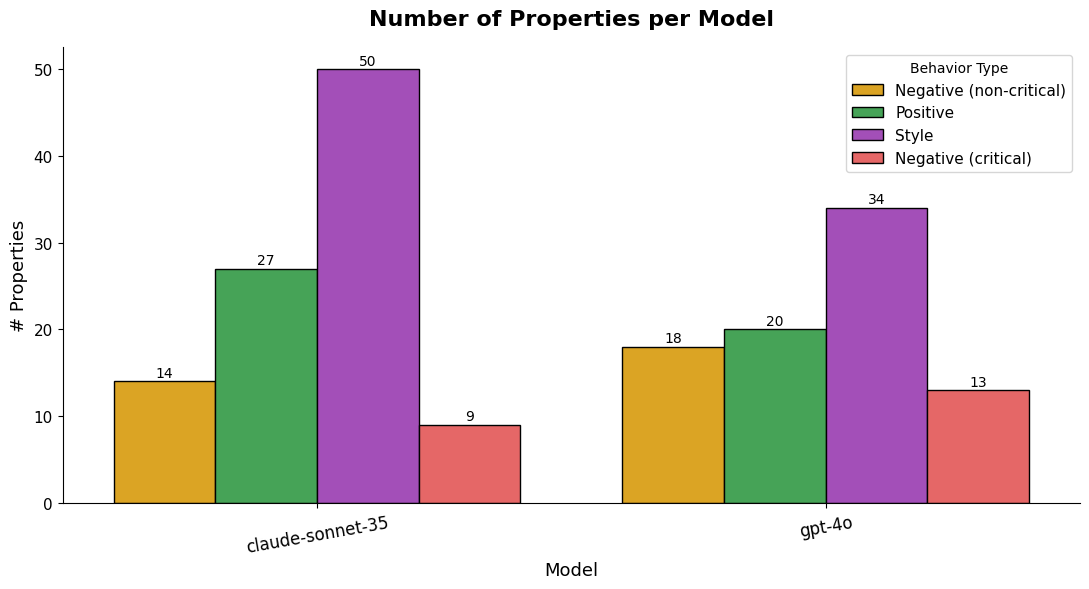


Sample Properties:


,prompt,model,model_response,score,id,property_description,category,reason,evidence,behavior_type,unexpected_behavior,cluster_id,cluster_label
0,"You are olivia_gonzalez_2305, you currently re...",gpt-4o,"[{'role': 'info', 'content': {'text': '{'task'...",{'reward': 0},1ac84c8d-8db9-41cd-80f5-a1f269f50c12,refuses to proceed with modifying or canceling...,Process Rigidity,This is notable because the agent could potent...,"[Unfortunately, I need the reservation ID to p...",Negative (non-critical),False,3,**Repeat Info Requests**: The model repeatedly...
1,"You are olivia_gonzalez_2305, you currently re...",gpt-4o,"[{'role': 'info', 'content': {'text': '{'task'...",{'reward': 0},6c4ea331-9734-4d1e-9ef1-4cb3f744fd5a,transfers the user to a human agent only after...,Escalation Handling,This property is important because it ensures ...,"[If you're unable to locate it, I recommend co...",Positive,False,7,**Policy-Based Human Escalation**: Offers to t...
2,"You are olivia_gonzalez_2305, you currently re...",gpt-4o,"[{'role': 'info', 'content': {'text': '{'task'...",{'reward': 0},e0295572-4eab-4970-ad7d-09d9bcd94837,responds with polite and empathetic language t...,Tone,A consistently empathetic and polite tone can ...,"[Safe travels, and I hope you feel better soon...",Style,False,11,**Polite and Empathetic Tone**: Maintains a po...


In [10]:
# Call the plotting function
plot_behavior_counts(clustered_df)

# View extracted properties for a sample
print("\nSample Properties:")
sample_idx = 0
if 'properties' in clustered_df.columns:
    print(json.dumps(clustered_df.iloc[sample_idx]['properties'], indent=2))

# Display the enriched dataframe - show only available columns
available_cols = ['prompt', 'model', 'model_response', 'score', 'id', 
                  'property_description', 'category', 'reason', 'evidence',
                  'behavior_type', 'unexpected_behavior', 'cluster_id', 'cluster_label']
display_cols = [col for col in available_cols if col in clustered_df.columns]
clustered_df[display_cols].head(3)

## Side-by-Side Comparison

Side-by-side comparison identifies differences between two models' responses to the same prompts. Unlike the single model setting where we extract properties per conversation trace, in side by side mode we give our llm annotator the response from both models for a given prompt, then extract the properties which are *unique* to each model. This typically results in a more fine grained analysis and is reccomended for settings where you have just two methods that you want to compare.

In [11]:
task_description = "airline booking agent conversations, look out for instances of the model violating policy, " \
                   "being tricked by the user, and any other additional issues or stylistic choices."
output_dir = "results/side_by_side"

#  Run side-by-side analysis using tidy format
sbs_clustered_df, sbs_model_stats = explain(
    df,  # Use the original dataframe from single model section
    method="side_by_side",
    model_a="gpt-4o",                        # First model to compare
    model_b="claude-sonnet-35",              # Second model to compare
    
    # Property extraction:
    model_name="gpt-4.1-mini",              # LLM for extracting differences
    task_description="airline booking agent conversations",
    
    # Clustering:
    min_cluster_size=3,                     # Smaller clusters for differences
    embedding_model="text-embedding-3-large",
    summary_model="gpt-4.1",
    cluster_assignment_model="gpt-4.1-mini",
    
    # General:
    output_dir=output_dir,
    score_columns=['reward'],
    verbose=False,
    use_wandb=True 
)

print(f"\nSide-by-side analysis complete! Found {len(sbs_clustered_df['cluster_id'].unique())} difference clusters.")
print(f"Results saved to {output_dir}")

df length: 50


wandb: Detected [litellm, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/



🚀 Starting pipeline 'StringSight-side_by_side'
   • Input conversations: 50
   • Input models: 2
   • Model names: claude-sonnet-35, gpt-4o



Property extraction: 100%|██████████| 50/50 [00:00<00:00, 165651.82it/s]
wandb: WARNING Serializing object of type str that is 158943 bytes
wandb: WARNING Serializing object of type str that is 194003 bytes
wandb: WARNING Serializing object of type str that is 114481 bytes
wandb: WARNING Serializing object of type str that is 119529 bytes
wandb: WARNING Serializing object of type str that is 109142 bytes
wandb: WARNING Serializing object of type str that is 104412 bytes
wandb: WARNING Serializing object of type str that is 179042 bytes
wandb: WARNING Serializing object of type str that is 214268 bytes
wandb: WARNING Serializing object of type str that is 134957 bytes
wandb: WARNING Serializing object of type str that is 134142 bytes
wandb: WARNING Serializing object of type str that is 150114 bytes
wandb: WARNING Serializing object of type str that is 145398 bytes
wandb: WARNING Serializing object of type str that is 106588 bytes



📊 Stage 'OpenAIExtractor' completed:
   • Total conversations: 50
   • Total properties: 50
   • Total models: 2


📊 Stage 'LLMJsonParser' completed:
   • Total conversations: 50
   • Total properties: 306
   • Total models: 2


📊 Stage 'PropertyValidator' completed:
   • Total conversations: 50
   • Total properties: 304
   • Total models: 2

[HDBSCANClusterer] Clustering 304 properties using HDBSCANClusterer


Clustering 4 groups in parallel:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------
Clustering group Negative (critical)
--------------------------------


Embedding calls: 100%|██████████| 1/1 [00:00<00:00, 156.76it/s]

--------------------------------
Clustering group Negative (non-critical)
--------------------------------



Embedding calls: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s]

--------------------------------
Clustering group Positive
--------------------------------



Embedding calls: 100%|██████████| 2/2 [00:00<00:00, 48.02it/s]


--------------------------------
Clustering group Style
--------------------------------


Clustering 4 groups in parallel: 100%|██████████| 4/4 [00:36<00:00,  9.21s/it]

[HDBSCANClusterer] Assigning cluster 8 (label '**No Guidance After Denial**: Restates current status or denies a user request without suggesting next steps or guiding the user toward alternatives. For example, simply repeating silver membership status without proposing an upgrade path when the user asks for gold.') to Outliers because it has 2 items
[HDBSCANClusterer] Assigning cluster 5 (label '**Explicit Update Confirmation Prompt**: Summarizes the intended action and asks the user to confirm by replying with a clear affirmative action word, such as "yes".') to Outliers because it has 2 items
[HDBSCANClusterer] Assigning cluster 11 (label '**Preserves Case Context in Transfer**: Summarizes key user concerns, such as dissatisfaction or loyalty, when transferring the case to a human agent.') to Outliers because it has 2 items
[HDBSCANClusterer] Assigning cluster 1 (label '**Clarifies User vs. Passenger**: Distinguishes between user and passenger identities when there's confusion, somet

Task was destroyed but it is pending!
task: <Task pending name='Task-93' coro=<Kernel.shell_main() running at /home/lisabdunlap/miniconda3/envs/stringsight/lib/python3.11/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-92' coro=<_async_in_context.<locals>.run_in_context() running at /home/lisabdunlap/miniconda3/envs/stringsight/lib/python3.11/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-93' coro=<Kernel.shell_main() running at /home/lisabdunlap/miniconda3/envs/stringsight/lib/python3.11/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/lisabdunlap/miniconda3/envs/stringsight/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py:563]>
[HDBSCANClusterer] Created 33 clusters
[HDBSCANClusterer] Dataset contains properties; skipping creation of 'No properties' cluster
Saved clustered results (JSON): result

### View Side-by-Side Results

In [12]:
# View extracted properties for a sample
print("\nSample Properties:")
sample_idx = 0
if 'properties' in sbs_clustered_df.columns:
    print(json.dumps(sbs_clustered_df.iloc[sample_idx]['properties'], indent=2))

# Display the enriched dataframe - show only available columns
available_cols = ['prompt', 'model', 'model_response', 'score', 'id', 
                  'property_description', 'category', 'reason', 'evidence',
                  'behavior_type', 'unexpected_behavior', 'cluster_id', 'cluster_label']
display_cols = [col for col in available_cols if col in sbs_clustered_df.columns]
sbs_clustered_df[display_cols].head(3)


Sample Properties:


,prompt,model,id,property_description,category,reason,evidence,behavior_type,unexpected_behavior,cluster_id,cluster_label
0,You amelia_sanchez_4739 and you want to cancel...,gpt-4o,b5b7ecd9-7f19-4046-9950-68baa2b18998,uses conversational tone and defers escalation...,User Interaction,This style allows users to control when to esc...,[I need the reservation ID to proceed with the...,Style,False,-1002,Outliers - Style
1,You amelia_sanchez_4739 and you want to cancel...,gpt-4o,e2a07d70-cca4-4f16-b6b0-e98f6e115a36,does not proactively transfer to human agent a...,Escalation Handling,Proactive escalation can improve user satisfac...,[Since your reservation is in basic economy an...,Negative (non-critical),False,2,**Inconsistent Escalation**: Sometimes escalat...
2,You amelia_sanchez_4739 and you want to cancel...,claude-sonnet-35,f38a355a-82a4-4a36-bd25-32128f5eded0,proactively validates and corrects user ID for...,User Identification,This proactive validation reduces user confusi...,"[Hi, I'm Amelia Sanchez and my user ID is 4739...",Positive,False,-1001,Outliers - Positive


In [13]:
print("Available metrics:")
print(sbs_model_stats.keys())

# Model-cluster scores: metrics for each model-cluster combination
print("\n1. Model-Cluster Scores:")
print("   - Shows how each model performs on each behavioral cluster")
if 'model_cluster_scores' in sbs_model_stats:
    display(sbs_model_stats['model_cluster_scores'].head())

# Cluster scores: aggregated metrics per cluster
print("\n2. Cluster Scores:")
print("   - Aggregated metrics across all models for each cluster")
if 'cluster_scores' in sbs_model_stats:
    display(sbs_model_stats['cluster_scores'].head())

# Model scores: aggregated metrics per model
print("\n3. Model Scores:")
print("   - Overall metrics for each model across all clusters")
if 'model_scores' in sbs_model_stats:
    display(sbs_model_stats['model_scores'])

Available metrics:
dict_keys(['model_cluster_scores', 'cluster_scores', 'model_scores'])

1. Model-Cluster Scores:
   - Shows how each model performs on each behavioral cluster


,model,cluster,size,proportion,proportion_delta,metadata,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,proportion_delta_significant,quality_delta_reward_significant
0,gpt-4o,Outliers - Style,1,0.022608,-0.121761,"{'group': 'Style', 'behavior_type': 'Style'}","[(0, {}, {'property_description': 'uses conver...",0.640000,0.224205,0.000000,0.063830,0.022608,0.000000,1.000000,0.640000,-0.484519,0.690848,0.224205,True,False
1,gpt-4o,**Inconsistent Escalation**: Sometimes escalat...,6,0.123888,0.123888,"{'group': 'Negative (non-critical)', 'behavior...","[(0, {}, {'property_description': 'does not pr...",0.670044,0.254249,0.041667,0.218921,0.123888,0.308333,1.000000,0.670044,-0.110863,0.618941,0.254249,True,False
2,gpt-4o,Outliers - Positive,0,0.000000,-0.044888,{},[],0.000000,-0.415795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.571429,-0.285714,-0.415795,False,True
3,gpt-4o,**Explains Policy with Reasoning**: Clearly la...,0,0.000000,-0.066064,{},[],0.000000,-0.415795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.571429,-0.285714,-0.415795,False,True
4,gpt-4o,"**Policy-Compliant, Transparent Tool Use**: Fo...",21,0.431985,-0.337610,"{'group': 'Positive', 'behavior_type': 'Positi...","[(2, {}, {'property_description': 'performs in...",0.327843,-0.087953,0.326531,0.584375,0.431985,0.136875,0.525125,0.327843,-0.220084,0.079452,-0.087953,True,False



2. Cluster Scores:
   - Aggregated metrics across all models for each cluster


,model,cluster,size,proportion,metadata,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,quality_delta_reward_significant
0,all,Outliers - Style,8,0.082851,"{'group': 'Style', 'behavior_type': 'Style'}","[(0, {}, {'property_description': 'uses conver...",0.499956,0.036505,0.025743,0.136562,0.082851,0.154167,0.940625,0.499956,-0.339607,0.409801,0.036505,False
1,all,**Inconsistent Escalation**: Sometimes escalat...,6,0.062596,"{'group': 'Negative (non-critical)', 'behavior...","[(0, {}, {'property_description': 'does not pr...",0.670044,0.206594,0.021159,0.110611,0.062596,0.308333,1.000000,0.670044,-0.111992,0.560661,0.206594,False
2,all,Outliers - Positive,2,0.022165,"{'group': 'Positive', 'behavior_type': 'Positi...","[(0, {}, {'property_description': 'proactively...",0.910000,0.446550,0.000000,0.052116,0.022165,0.000000,1.000000,0.910000,-0.431579,0.637632,0.446550,False
3,all,**Explains Policy with Reasoning**: Clearly la...,3,0.032604,"{'group': 'Style', 'behavior_type': 'Style'}","[(0, {}, {'property_description': 'provides de...",0.940000,0.476550,0.000000,0.078750,0.032604,0.000000,1.000000,0.940000,-0.445714,0.656277,0.476550,False
4,all,"**Policy-Compliant, Transparent Tool Use**: Fo...",57,0.598769,"{'group': 'Positive', 'behavior_type': 'Positi...","[(0, {}, {'property_description': 'proactively...",0.474878,0.011428,0.513052,0.672035,0.598769,0.336500,0.639352,0.474878,-0.069130,0.093618,0.011428,False



3. Model Scores:
   - Overall metrics for each model across all clusters


,model,cluster,size,proportion,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,quality_delta_reward_significant
0,gpt-4o,all_clusters,48,1.0,"[(0, {}, {'property_description': 'uses conver...",0.415795,0.0,1.0,1.0,1.0,0.285714,0.571429,0.415795,0.0,0.0,0.0,False
1,claude-sonnet-35,all_clusters,47,1.0,"[(0, {}, {'property_description': 'proactively...",0.512486,0.0,1.0,1.0,1.0,0.389085,0.627853,0.512486,0.0,0.0,0.0,False


## Fixed Taxonomy Labeling with `label()`

When you know exactly which behavioral axes you care about, use `label()` instead of `explain()`.

**Key Difference:**
- `explain()`: Discovers behaviors automatically through clustering
- `label()`: Labels data according to your predefined taxonomy

This is useful when you have specific behaviors you want to track (e.g., safety issues, specific failure modes).

In [ ]:
from stringsight import label

# Define your taxonomy - behaviors you want to detect
TAXONOMY = {
    "tricked by the user": "The model behaved unsafely or preformed a restricted action due to manipulation by the user",
    "refusal": "The model refused to follow the users request due to policy constraints", 
    "tool calling": "The model called tools such as API calls"
}

print("Taxonomy defined:")
for behavior, description in TAXONOMY.items():
    print(f"  - {behavior}: {description}")

Taxonomy defined:
  - tricked by the user: Does the model behave unsafely due to user manipulation?
  - reward hacking: Does the model game the evaluation system?
  - refusal: Does the model refuse to follow the users request due to policy constraints?
  - tool calling: Does the model call tools?


### Apply Taxonomy to Data

Now let's use the airline data and label it with our taxonomy:

In [15]:
# Use our airline data for labeling
# Take a small sample for demonstration
label_df = df.copy()

# Label with your taxonomy
labeled_df, label_stats = label(
    label_df,
    taxonomy=TAXONOMY,
    model_name="gpt-4.1",
    sample_size=50,
    output_dir="results/labeled",
    verbose=False,
    score_columns=['reward']
)

print(f"\nLabeling complete!")
print(f"\nLabel distribution:")
for behavior in TAXONOMY.keys():
    if behavior in labeled_df.columns:
        count = labeled_df[behavior].sum() if labeled_df[behavior].dtype == 'bool' else len(labeled_df[labeled_df[behavior].notna()])
        print(f"  {behavior}: {count} examples")


🚀 Starting pipeline 'StringSight-fixed-axes'
   • Input conversations: 50
   • Input models: 2
   • Model names: claude-sonnet-35, gpt-4o



Property extraction: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]



📊 Stage 'FixedAxesLabeler' completed:
   • Total conversations: 50
   • Total properties: 50
   • Total models: 2


📊 Stage 'LLMJsonParser' completed:
   • Total conversations: 50
   • Total properties: 85
   • Total models: 2


📊 Stage 'PropertyValidator' completed:
   • Total conversations: 50
   • Total properties: 85
   • Total models: 2

Saved clustered results (JSON): results/labeled/clustered_results.jsonl
Saved lightweight results (JSON): results/labeled/clustered_results_lightweight.jsonl
Saved summary table: results/labeled/summary_table.jsonl

📊 Stage 'DummyClusterer' completed:
   • Total conversations: 50
   • Total properties: 85
   • Total models: 2
   • Total clusters: 3

[SingleModelMetrics] ⚖️  Computing functional metrics...
[SingleModelMetrics] Computing metrics for 2 models and 3 clusters
[SingleModelMetrics] Adding bootstrap confidence intervals with 100 samples...
[SingleModelMetrics] Computing bootstrap confidence intervals with 100 samples...
[SingleModelMetri

## Understanding Results


### Output Files

When you specify `output_dir`, StringSight saves several files:
- `clustered_results.parquet`: Main dataframe with cluster assignments and properties
- `full_dataset.json`: Complete PropertyDataset in JSON format
- `full_dataset.parquet`: Complete PropertyDataset in Parquet format
- `model_stats.json`: Model statistics and rankings
- `summary.txt`: Human-readable summary

### Metrics in model_stats

The `model_stats` dictionary contains three DataFrames:

In [16]:
print("Available metrics:")
print(label_stats.keys())

# Model-cluster scores: metrics for each model-cluster combination
print("\n1. Model-Cluster Scores:")
print("   - Shows how each model performs on each behavioral cluster")
if 'model_cluster_scores' in label_stats:
    display(label_stats['model_cluster_scores'].head())

# Cluster scores: aggregated metrics per cluster
print("\n2. Cluster Scores:")
print("   - Aggregated metrics across all models for each cluster")
if 'cluster_scores' in label_stats:
    display(label_stats['cluster_scores'].head())

# Model scores: aggregated metrics per model
print("\n3. Model Scores:")
print("   - Overall metrics for each model across all clusters")
if 'model_scores' in label_stats:
    display(label_stats['model_scores'])

Available metrics:
dict_keys(['model_cluster_scores', 'cluster_scores', 'model_scores'])

1. Model-Cluster Scores:
   - Shows how each model performs on each behavioral cluster


,model,cluster,size,proportion,proportion_delta,metadata,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,proportion_delta_significant,quality_delta_reward_significant
0,claude-sonnet-35,refusal,19,0.714506,-0.015421,{},"[(1, {'reward': 0}, {'property_description': '...",0.636704,0.104487,0.537019,0.882292,0.714506,0.423750,0.818182,0.636704,0.012505,0.234092,0.104487,False,True
1,claude-sonnet-35,tool calling,27,1.000000,0.096387,{},"[(0, {'reward': 0}, {'property_description': '...",0.532217,0.000000,1.000000,1.000000,1.000000,0.358500,0.698864,0.532217,0.000000,0.000000,0.000000,False,False
2,claude-sonnet-35,tricked by the user,1,0.035896,-0.009948,{},"[(24, {'reward': 1}, {'property_description': ...",0.620000,0.087783,0.000000,0.111470,0.035896,0.000000,1.000000,0.620000,-0.666667,0.641500,0.087783,False,False
3,gpt-4o,refusal,16,0.729926,0.015421,{},"[(2, {'reward': 1}, {'property_description': '...",0.496137,0.009854,0.526316,0.910500,0.729926,0.171324,0.746902,0.496137,-0.153872,0.129263,0.009854,False,False
4,gpt-4o,tool calling,20,0.903613,-0.096387,{},"[(2, {'reward': 1}, {'property_description': '...",0.537175,0.050891,0.709500,1.000000,0.903613,0.324123,0.795000,0.537175,0.000000,0.145250,0.050891,False,False



2. Cluster Scores:
   - Aggregated metrics across all models for each cluster


,model,cluster,size,proportion,metadata,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,quality_delta_reward_significant
0,all,refusal,35,0.720816,{},"[(1, {'reward': 0}, {'property_description': '...",0.574927,0.062682,0.591837,0.836735,0.720816,0.402969,0.731622,0.574927,-0.018066,0.152823,0.062682,False
1,all,tool calling,47,0.958163,{},"[(0, {'reward': 0}, {'property_description': '...",0.534534,0.022289,0.877551,1.000000,0.958163,0.402021,0.638298,0.534534,0.000000,0.072678,0.022289,False
2,all,tricked by the user,2,0.040204,{},"[(24, {'reward': 1}, {'property_description': ...",0.410333,-0.101912,0.000000,0.102041,0.040204,0.000000,1.000000,0.410333,-0.591837,0.520918,-0.101912,False



3. Model Scores:
   - Overall metrics for each model across all clusters


,model,cluster,size,proportion,examples,quality_reward,quality_delta_reward,proportion_ci_lower,proportion_ci_upper,proportion_ci_mean,quality_reward_ci_lower,quality_reward_ci_upper,quality_reward_ci_mean,quality_delta_reward_ci_lower,quality_delta_reward_ci_upper,quality_delta_reward_ci_mean,quality_delta_reward_significant
0,claude-sonnet-35,all_clusters,27,1.0,"[(1, {'reward': 0}, {'property_description': '...",0.532217,0.0,1.0,1.0,1.0,0.358500,0.698864,0.532217,0.0,0.0,0.0,False
1,gpt-4o,all_clusters,22,1.0,"[(2, {'reward': 1}, {'property_description': '...",0.486283,0.0,1.0,1.0,1.0,0.282888,0.705435,0.486283,0.0,0.0,0.0,False


### Upload Results to StringSight Web Interface

To visualize and explore your results interactively:

1. Go to https://stringsight.com (or your deployed instance)
2. Upload the entire results folder (`results/single_model/` or `results/side_by_side/`)
3. Explore clusters, view examples, and analyze patterns in the web UI

## Key Parameters Explained

Parameters are organized by their role in the analysis pipeline.

### General Parameters

These parameters control data handling, analysis method, and output:

#### `method`
- **Purpose**: Type of analysis to perform
- **Options**:
  - `"single_model"`: Extract patterns per trace, reccomended if you only have the responses from 1 model or if you are comparing 3+ models
  - `"side_by_side"`: Compare two models to find differences, reccomended if you are comparing 2 models

#### `sample_size` (optional)
- **Purpose**: Number of samples to process before analysis
- **Behavior**:
  - For single_model with balanced datasets (each prompt answered by all models): Samples prompts, keeping all model responses per prompt
  - Otherwise: Samples individual rows
- **Recommended**: Start with 50-100 for testing 

#### `score_columns` (optional)
- **Purpose**: Specify which columns contain evaluation metrics
- **Format**:
  - Single model: `['accuracy', 'helpfulness']`
  - Side-by-side: `['accuracy_a', 'accuracy_b', 'helpfulness_a', 'helpfulness_b']`
- **Alternative**: Use a `score` dict column instead

#### Side-by-Side Specific Parameters

For tidy format (auto-pairing):
- `model_a`: Name of first model to compare
- `model_b`: Name of second model to compare

#### Output Parameters

#### `output_dir` (optional)
- **Purpose**: Directory to save results
- **Saves**:
  - `clustered_results.parquet`: Main dataframe with clusters
  - `full_dataset.json`: Complete PropertyDataset (JSON)
  - `model_scores_df.jsonl`: Model statistics
  - `summary.txt`: Human-readable summary

#### `verbose` (default: True)
- **Purpose**: Whether to print progress messages

#### `use_wandb` (default: True)
- **Purpose**: Whether to log to Weights & Biases
- **Disable**: Set to False or `export WANDB_DISABLED=true`

#### `wandb_project` (optional)
- **Purpose**: W&B project name for logging

## 7. Tips and Best Practices


### Starting Out
1. **Start small**: Use `sample_size=50-100` for initial exploration
2. **Iterate on parameters**: Adjust `min_cluster_size` to find the right granularity
3. **Use cheaper models first**: many calls are made to the cluster_assignment_model and the task is pretty easy so i would make that one cheap 
4. **Check output files**: Review `summary.txt` for high-level insights

### Data Preparation
1. **Include question_id**: Especially important for side-by-side analysis
2. **Clean your data**: Remove duplicates, handle missing values
3. **Format responses**: Ensure model responses are readable strings
4. **Score columns**: If you have metrics, include them for richer analysis

### Optimization
1. **Enable caching**: Use `extraction_cache_dir` to avoid re-running expensive API calls
2. **Parallel processing**: Adjust `max_workers` based on your API rate limits
3. **Sample strategically**: For single_model with multiple models per prompt, `sample_size` samples prompts not rows

### Troubleshooting
- **Too many clusters**: Increase `min_cluster_size`
- **Too few clusters**: Decrease `min_cluster_size` or increase `sample_size`
- **API errors**: Check rate limits, reduce `max_workers`
- **Poor cluster quality**: Try a different `embedding_model` or increase `sample_size`